In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce
import requests

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt


In [4]:
# Подгрузим наши данные из соревнования
# DATA_DIR = '/kaggle/input/sf-booking/' # kaggle
DATA_DIR = 'kaggle/input/sf-booking/'  # windows
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv')  # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')  # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')  # самбмишн

In [5]:
print('Количество дубликатов: {}'.format(
    df_train[df_train.duplicated()].shape[0]))
# Удаляем дубликаты:
df_train = df_train.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(df_train.shape))

Количество дубликатов: 307
Размер таблицы после удаления дубликатов: (386496, 17)


In [6]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

In [7]:
df_train.head(2)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [10]:
sample_submission.head(2)


,reviewer_score,id
0,1,488440
1,10,274649


In [11]:
sample_submission.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['reviewer_score'] = 0

df = pd.concat([df_test, df_train], ignore_index=True)  # объединяем

In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

# 1 Изучение пропусков


In [14]:
(df.isna().sum() / len(df)).round(4) * 100


hotel_address                                 0.00
additional_number_of_scoring                  0.00
review_date                                   0.00
average_score                                 0.00
hotel_name                                    0.00
reviewer_nationality                          0.00
negative_review                               0.00
review_total_negative_word_counts             0.00
total_number_of_reviews                       0.00
positive_review                               0.00
review_total_positive_word_counts             0.00
total_number_of_reviews_reviewer_has_given    0.00
tags                                          0.00
days_since_review                             0.00
lat                                           0.63
lng                                           0.63
sample                                        0.00
reviewer_score                                0.00
dtype: float64

<Axes: >

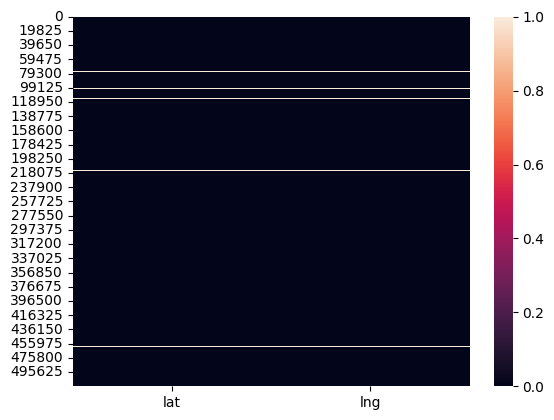

In [15]:
sns.heatmap(df[['lat', 'lng']].isnull())

Есть пропуски только в координатах, которые составляют менее 1%. Возможно удаление этих строк не повлечет ухудшение модели. Однако , попробуем восстановить данные на основе адреса


# 2 Первоначальный анализ данных по столбцам


-     hotel_address — адрес отеля;
-     review_date — дата, когда рецензент разместил соответствующий отзыв;
-     average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
-     hotel_name — название отеля;
-     reviewer_nationality — страна рецензента;
-     negative_review — отрицательный отзыв, который рецензент дал отелю;
-     review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
-     positive_review — положительный отзыв, который рецензент дал отелю;
-     review_total_positive_word_counts — общее количество слов в положительном отзыве.
-     reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
-     total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
-     total_number_of_reviews — общее количество действительных отзывов об отеле;
-     tags — теги, которые рецензент дал отелю;
-     days_since_review — количество дней между датой проверки и датой очистки;
-     additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
-     lat — географическая широта отеля;
-     lng — географическая долгота отеля.


In [16]:
df.describe(include='all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
count,515431,515431.000000,515431,515431.000000,515431,515431,515431,515431.000000,515431.000000,515431,515431.000000,515431.000000,515431,515431,512163.000000,512163.000000,515431.00000,515431.000000
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,55242,731,NaN,NaN,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN,NaN,NaN
freq,4789,NaN,2584,NaN,4789,245165,127816,NaN,NaN,35924,NaN,NaN,5101,2584,NaN,NaN,NaN,NaN
mean,NaN,498.275079,NaN,8.397630,NaN,NaN,NaN,18.539760,2744.259084,NaN,17.777342,7.165215,NaN,NaN,49.442788,2.824057,0.74985,6.296715
std,NaN,500.618961,NaN,0.548033,NaN,NaN,NaN,29.690973,2317.823718,NaN,21.803204,11.038742,NaN,NaN,3.467323,4.580730,0.43310,3.902967
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,NaN,NaN,41.328376,-0.369758,0.00000,0.000000
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,NaN,NaN,48.214277,-0.143372,0.00000,0.000000
50%,NaN,342.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,NaN,NaN,51.499981,-0.000250,1.00000,7.900000
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3633.000000,NaN,22.000000,8.000000,NaN,NaN,51.516288,4.834443,1.00000,9.600000


## 2.1 Столбцы hotel_address и hotel_name


In [17]:
# уникальный адрес с названием
df.drop_duplicates(subset="hotel_address")['hotel_name'].value_counts()

Hotel Regina                            3
Hotel Da Vinci                          1
Sunotel Club Central                    1
Austria Trend Hotel Doppio Wien         1
Camperio House Suites Apartments        1
                                       ..
Cordial Theaterhotel Wien               1
Hotel Cavendish                         1
WestCord Fashion Hotel Amsterdam        1
K K Hotel George                        1
Mercure Paris Bastille Saint Antoine    1
Name: hotel_name, Length: 1491, dtype: int64

In [18]:
# Просмотр адреса отеля с одинаковым названием
df[df['hotel_name'] == 'Hotel Regina']['hotel_address'].value_counts()

Bergara 2 4 Eixample 08002 Barcelona Spain                    590
Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
Name: hotel_address, dtype: int64

In [19]:
# уникальное название с адресом
df.drop_duplicates(subset="hotel_name")['hotel_address'].value_counts()

8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom                2
Via Senigallia 6 20161 Milan Italy                                                        1
Stephansplatz 9 01 Innere Stadt 1010 Vienna Austria                                       1
Rennweg 99 Rinnboeckstrasse 1 03 Landstra e 1030 Vienna Austria                           1
Via Camperio 9 Milan City Center 20123 Milan Italy                                        1
                                                                                         ..
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria                                  1
75 Gower Street Camden London WC1E 6HJ United Kingdom                                     1
Hendrikje Stoffelstraat 1 Slotervaart 1058 GC Amsterdam Netherlands                       1
1 15 Templeton Place Earl s Court Kensington and Chelsea London SW5 9NB United Kingdom    1
64 Rue Crozatier 12th arr 75012 Paris France                                    

In [20]:
# Просмотр названия отеля с одинаковым адресом
df[df['hotel_address'] == '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom']['hotel_name'].value_counts()

Club Quarters Hotel Trafalgar Square    945
The Grand at Trafalgar Square           733
Name: hotel_name, dtype: int64

In [21]:
# Исправление не оригинального названия добавлением страны
df.loc[df['hotel_address'] == 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', ['hotel_name']] = (
    df.loc[df['hotel_address'] == 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', ['hotel_name']].apply(lambda x: "Hotel Regina Austria", axis=1)
)


In [22]:
# Исправление не оригинального названия добавлением страны
df.loc[df['hotel_address'] == 'Bergara 2 4 Eixample 08002 Barcelona Spain', ['hotel_name']] = (
    df.loc[df['hotel_address'] == 'Bergara 2 4 Eixample 08002 Barcelona Spain', ['hotel_name']].apply(lambda x: 'Hotel Regina Spain', axis=1)
)


Вывод по столбцам адрес и название отеля: 3 отеля имеют одинаковое название, но разный адрес(страну), значит всего представлено 1494 отеля. Из них два имеют одинаковый адрес в Лондоне(поиск в гугле подсказал, что это разные отели)

## 2.2 Столбец 'average_score'


In [23]:
df['average_score'].value_counts()


8.4    41222
8.1    38120
8.5    38066
8.7    37798
8.6    36945
8.2    34847
8.3    32880
8.8    30836
8.9    28487
8.0    22341
9.1    21379
9.0    21001
7.8    19894
7.9    14983
7.5    13719
9.2    12935
9.3    12659
7.7    11829
9.4     9339
7.1     6780
7.6     6684
7.4     6300
7.3     3997
7.0     3899
6.9     1737
6.8     1327
9.5     1207
6.4     1163
6.7      965
9.6      915
7.2      684
6.6      400
5.2       65
9.8       28
Name: average_score, dtype: int64

In [24]:
# Дату переводим в формат даты (вспомогательные вычисления)
df['review_date'] = pd.to_datetime(df['review_date'], format='%m/%d/%Y')
df['year'] = df['review_date'].dt.year

In [25]:
# Посмотрим на столбец 'average_score' в связке с названием и годом
df.groupby(['hotel_address', 'average_score', 'year']).count().head(15)


additional_number_of_scoring  \
hotel_address                                      average_score year                                 
 s Gravesandestraat 55 Oost 1092 AA Amsterdam N... 7.7           2015                           104   
                                                                 2016                           189   
                                                                 2017                           112   
1 15 Templeton Place Earl s Court Kensington an... 8.5           2015                            75   
                                                                 2016                           386   
                                                                 2017                           105   
1 2 Serjeant s Inn Fleet Street City of London ... 9.2           2015                           230   
                                                                 2016                           611   
                                                                 2017                           196   
1 3 Queens Garden Westminster Borough London W2... 7.7           2015                           287   
                                                                 2016                          1036   
                                                                 2017                           447   
1 3 Rue d Argentine 16th arr 75116 Paris France    8.4           2015                            13   
                                                                 2016                            15   
                                                                 2017                             7   

                                                                       review_date  \
hotel_address                                      average_score year                
 s Gravesandestraat 55 Oost 1092 AA Amsterdam N... 7.7           2015          104   
                                                                 2016          189   
                                                                 2017          112   
1 15 Templeton Place Earl s Court Kensington an... 8.5           2015           75   
                                                                 2016          386   
                                                                 2017          105   
1 2 Serjeant s Inn Fleet Street City of London ... 9.2           2015          230   
                                                                 2016          611   
                                                                 2017          196   
1 3 Queens Garden Westminster Borough London W2... 7.7           2015          287   
                                                                 2016         1036   
                                                                 2017          447   
1 3 Rue d Argentine 16th arr 75116 Paris France    8.4           2015           13   
                                                                 2016           15   
                                                                 2017            7   

                                                                       hotel_name  \
hotel_address                                      average_score year               
 s Gravesandestraat 55 Oost 1092 AA Amsterdam N... 7.7           2015         104   
                                                                 2016         189   
                                                                 2017         112   
1 15 Templeton Place Earl s Court Kensington an... 8.5           2015          75   
                                                                 2016         386   
                                                                 2017         105   
1 2 Serjeant s Inn Fleet Street City of London ... 9.2           2015         230   
                                                                 2016         611   
      

** Вывод: Каждому отелю соответствует средний балл , который не зависит от года **


In [26]:
#  Удаление столбца с годом (пока это лишняя информация)
df = df.drop(['year'], axis=1)


## 2.3 Исследование отзывов


In [27]:
# Проверяем корректность количества слов в положительном отзыве
df['positive_review'] = df['positive_review'].apply(lambda x: x.strip())  # удаляем лишние пробелы из строк
df['review_total_positive_word_counts_new'] = df['positive_review'].apply(lambda x: len(x.split(' '))) # новый столбец
# Проверка
df[df['review_total_positive_word_counts_new'] != df['review_total_positive_word_counts']][[
    'positive_review', 'review_total_positive_word_counts_new', 'review_total_positive_word_counts']]


,positive_review,review_total_positive_word_counts_new,review_total_positive_word_counts
0,Hotel was great clean friendly staff free brea...,60,62
1,No Positive,2,0
2,Nice welcoming and service,4,5
3,Everything including the nice upgrade The Hote...,26,27
4,Lovely hotel v welcoming staff,5,7
...,...,...,...
515426,Tr s proche du metro Earl s court,8,10
515427,The bed was so comfy I stayed with my boyfrien...,91,93
515428,great location simple check in out nice shower,8,9
515429,Location and very comfy bed,5,6


In [28]:
# Посмотрим разницу по модулю больше 2
mask = abs((df['review_total_positive_word_counts_new'] - df['review_total_positive_word_counts'])) > 2
df[mask][['positive_review', 'review_total_positive_word_counts_new',
          'review_total_positive_word_counts']]

,positive_review,review_total_positive_word_counts_new,review_total_positive_word_counts


In [29]:
# Проверяем корректность количества слов в отрицательном отзыве
df['negative_review'] = df['negative_review'].apply(lambda x: x.strip())  # удаляем лишние пробелы из строк
df['review_total_negative_word_counts_new'] = df['negative_review'].apply(lambda x: len(x.split(' ')))
df[df['review_total_negative_word_counts_new'] != df['review_total_negative_word_counts']][[
    'negative_review', 'review_total_negative_word_counts_new', 'review_total_negative_word_counts']]

,negative_review,review_total_negative_word_counts_new,review_total_negative_word_counts
0,Would have appreciated a shop in the hotel tha...,50,52
1,No tissue paper box was present at the room,9,10
2,Pillows,1,3
3,No Negative,2,0
4,No Negative,2,0
...,...,...,...
515426,No Negative,2,0
515427,No Negative,2,0
515428,room is really small but guess is normal in Lo...,10,12
515429,No Negative,2,0


In [30]:
# Посмотрим разницу по модулю больше 2
mask = abs(df['review_total_negative_word_counts_new'] - df['review_total_negative_word_counts']) > 2
df[mask][['negative_review', 'review_total_negative_word_counts_new', 'review_total_negative_word_counts']]

,negative_review,review_total_negative_word_counts_new,review_total_negative_word_counts


In [31]:
# Количетво ячеек содержащие слова 'Nothing','No Negative' для отрицательных отзывов
lst = ['Nothing', 'No Negative']
df[df['negative_review'].str.contains('|'.join(lst), case=False)]['negative_review'].count()

166616

In [32]:
# Количество пустых ячеек
df[df['negative_review'] == '']['negative_review'].count()


849

In [33]:
def has_negative_review(arg):
    '''Функция определяет, есть ли в отзыве негатив'''
    ''' Как реализовать с помощью регулярных выражений? И будет ли код более качественным?'''

    list_fullmatch = [' ', 'nan', 'na', '0', 'null', 'none', 'n/a', 'n a']
    list_contains = ['no negative', 'nothing']

    for i in list_fullmatch:
        if i == arg.lower():
            return 0
    for i in list_contains:
        if i in arg.lower():
            return 0
    return 1

In [34]:
# Формирование нового столбца с информацией о наличии положительной словесной обратной связи
# и просмотр полученных значений
df['negative_boole'] = df['negative_review'].apply(has_negative_review)
df['negative_boole'].value_counts()


1    345221
0    170210
Name: negative_boole, dtype: int64

In [35]:
# Количетво ячеек содержащие слова 'Nothing','No Positive' для положительных отзывов
lst = ['Nothing', 'No Positive']
df[df['positive_review'].str.contains('|'.join(lst), case=False)]['positive_review'].count()

42497

In [36]:
# Количество пустых ячеек
df[df['positive_review'] == '']['positive_review'].count()


183

In [37]:
def has_positive_review(arg):
    '''Функция определяет, есть ли в отзыве позитив'''
    ''' Как реализовать с помощью регулярных выражений? И будет ли код более качественным?'''

    list_fullmatch = [' ', 'nan', 'na', '0', 'null', 'none', 'n/a', 'n a']
    list_contains = ['no positive', 'nothing']

    for i in list_fullmatch:
        if i == arg.lower():
            return 0
    for i in list_contains:
        if i in arg.lower():
            return 0
    return 1

In [38]:
# Формирование нового столбца с информацией о наличии отрицательной словесной обратной связи
# и просмотр полученных значений
df['positive_boole'] = df['positive_review'].apply(has_positive_review)
df['positive_boole'].value_counts()


1    472821
0     42610
Name: positive_boole, dtype: int64

In [39]:
# Заменим значение в новых столбцах с количеством слов на 0 с пустыми отзывами
mask_pos = df['positive_boole'] == 0
mask_neg = df['negative_boole'] == 0
df.loc[mask_pos, ['review_total_positive_word_counts_new']] = df.loc[mask_pos,
                                                                     ['review_total_positive_word_counts_new']].apply(lambda x: 0, axis=1)
df.loc[mask_neg, ['review_total_negative_word_counts_new']] = df.loc[mask_neg,
                                                                     ['review_total_negative_word_counts_new']].apply(lambda x: 0, axis=1)


In [40]:
# Количество отзывов, которые не имеют словесной обратной связи
df[(df['positive_boole'] == 0) & (df['negative_boole'] == 0)].groupby('hotel_name')['average_score'].count().sum()

2984

In [41]:
# распределение оценок по отзывам не имеющих обратной связи
df[(df['positive_boole'] == 0) & (df['negative_boole'] == 0)]['reviewer_score'].value_counts()

10.0    973
0.0     725
9.6     284
9.2     133
8.8      89
7.5      65
5.0      65
8.3      63
3.8      62
2.5      60
4.2      57
3.3      56
5.4      50
7.9      47
4.6      43
7.1      43
2.9      42
6.3      38
5.8      37
6.7      34
9.5       4
4.5       3
6.0       1
3.1       1
7.0       1
5.5       1
9.0       1
9.4       1
8.5       1
6.5       1
4.0       1
3.0       1
6.9       1
Name: reviewer_score, dtype: int64

Вывод: Количество отзывов, которые не имеют словесной обратной связи и низкие оценки общей массе не велико. Заполнить ее, какой либо информацией не представляется возможным.
Создадим новый признак: количество слов в положительном отзыве минус количество слов в отрицательном отзыве. Старые признаки количества слов в отзывах удалять не будем, они будут служить маркерами наличия словесной обратной связи


In [42]:
#  Удаление столбцов с новым количеством слов и столбцов содержащие отзывы
df = df.drop(['review_total_negative_word_counts_new', 'review_total_positive_word_counts_new',
             'negative_review', 'positive_review'], axis=1)

In [43]:
# Новый признак:
df['count_word_positive'] = df['review_total_positive_word_counts'] - df['review_total_negative_word_counts']

## 2.4 Столбцы 'additional_number_of_scoring' и 'total_number_of_reviews'


In [44]:
# Посмотрим на столбцы в связке с названием отеля
df.groupby(['hotel_name', 'total_number_of_reviews', 'additional_number_of_scoring'])['average_score'].count()

hotel_name                          total_number_of_reviews  additional_number_of_scoring
11 Cadogan Gardens                  393                      101                              159
1K Hotel                            663                      69                               148
25hours Hotel beim MuseumsQuartier  4324                     391                              689
41                                  244                      66                               103
45 Park Lane Dorchester Collection  68                       27                                28
                                                                                             ... 
citizenM London Bankside            3802                     804                             1517
citizenM London Shoreditch          2113                     500                              838
citizenM Tower of London            4672                     832                             1683
every hotel Piccadilly      

Вывод: количество отзывов и количество оценок без проверки - статичные параметры и уникальны для каждого отеля. \*\*


## 2.5 Столбец days_since_review


In [45]:
# Перевод в числовой формат
df['days_since_review'] = df['days_since_review'].apply(lambda x: int(x[:-4]))


In [46]:
df[['days_since_review', 'review_date']]

,days_since_review,review_date
0,13,2017-07-21
1,234,2016-12-12
2,616,2015-11-26
3,656,2015-10-17
4,444,2016-05-16
...,...,...
515426,106,2017-04-19
515427,171,2017-02-13
515428,543,2016-02-07
515429,74,2017-05-21


In [47]:
max_data = df['review_date'].max()
max_data - df['review_date']


0         13 days
1        234 days
2        616 days
3        656 days
4        444 days
           ...   
515426   106 days
515427   171 days
515428   543 days
515429    74 days
515430   363 days
Name: review_date, Length: 515431, dtype: timedelta64[ns]

**Вывод: Столбец содержит информацию о днях вычесленных по формуле: max_data - df['review_date']**


## 2.6 Изучение целевой переменной reviewer_score


In [48]:
df['reviewer_score'].value_counts().sort_index()


0.0     128935
2.5       1628
2.9       1207
3.0         25
3.1          6
3.3       2058
3.5         61
3.8       3012
4.0         66
4.2       3822
4.4          9
4.5         97
4.6       4651
5.0       6268
5.4       7079
5.5        161
5.6         13
5.8       8953
6.0        184
6.3      11238
6.5        274
6.7      14098
6.9         23
7.0        292
7.1      18518
7.5      26136
7.9      24881
8.0        388
8.1         28
8.3      30881
8.5        379
8.8      34767
9.0        483
9.2      44020
9.4         47
9.5        523
9.6      53471
10.0     86749
Name: reviewer_score, dtype: int64

**Вывод: итоговый прогноз необходимо округлить**


# 3 Преобразование признаков и создание новых


In [49]:
# Новый призкнак total_number_of_scoring
df['total_number_of_scoring'] = df['total_number_of_reviews'] - \
    df['additional_number_of_scoring']

In [50]:
# Кодирование имени отеля
# указываем столбец для кодирования
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
type_bin = bin_encoder.fit_transform(df['hotel_name'])
df = pd.concat([df, type_bin], axis=1)
df = df.drop(['hotel_name'], axis=1)  # удаление исходного столбца

### 3.1 Кодирование даты. Выделим месяц отзыва, день недели


In [51]:
# Формирование новых признака - день недели отзыва
review_date_week = pd.DataFrame(df['review_date'].dt.day_of_week)
# указываем столбец для кодирования
encoder = ce.OneHotEncoder(cols=['review_date'], use_cat_names=True)
type_bin = encoder.fit_transform(review_date_week['review_date'])
df = pd.concat([df, type_bin], axis=1)

In [52]:
# Формирование новых признака - месяц отзыва
review_date_month = pd.DataFrame(df['review_date'].dt.month)
review_date_month.columns = ['review_date_month']
# указываем столбец для кодирования
encoder = ce.OneHotEncoder(cols=['review_date_month'], use_cat_names=True)
type_bin = encoder.fit_transform(review_date_month['review_date_month'])
df = pd.concat([df, type_bin], axis=1)

In [53]:
df = df.drop(['review_date'], axis=1)

### 3.2 Исследование стран рецензентов


In [54]:
df['reviewer_nationality'].value_counts()


 United Kingdom               245165
 United States of America      35390
 Australia                     21663
 Ireland                       14820
 United Arab Emirates          10230
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

In [55]:
# Количество пустых значений
df[df['reviewer_nationality'] == ' '].shape[0]

523

In [56]:
# Удаляем лишние пробелы и заполняем пропуски самой популярной страной
df['reviewer_nationality'] = df['reviewer_nationality'].apply(
    lambda x: 'United Kingdom' if x == ' ' else x[1:-1])

In [57]:
# Список уникальных стран рецензентов
s1 = pd.DataFrame(df['reviewer_nationality'].unique())
s1.columns = ['Countries']
s1


,Countries
0,United Kingdom
1,Belgium
2,Sweden
3,United States of America
4,Ecuador
...,...
221,East Timor
222,Svalbard Jan Mayen
223,Northern Mariana Islands
224,Central Africa Republic


In [58]:
# Таблица со стороннего ресурса стран с координатами
url = 'https://alextyurin.ru/2016/04/страны-столицы-координаты/'
response = requests.get(url)
tables = pd.read_html(response.text)
df_capital = tables[0][['Capital', 'Countries', 'LAT', 'LONG']]

In [59]:
# Список уникальных стран с ресурса
s2 = df_capital[['Countries']]
s2


,Countries
0,Afghanistan
1,Albania
2,Algeria
3,American Samoa
4,Andorra
...,...
232,Wallis and Futuna Islands
233,Western Sahara
234,Yemen
235,Zambia


In [60]:
# set(s2['Countries'].unique()) - set(s1_s2[s1_s2['Capital'].isnull()==False]['Countries'].unique())

In [61]:
# Словарь для не совпадающих стран
dict_cap = {'Abkhazia Georgia': 'Georgia',
            'Antigua Barbuda': 'Antigua and Barbuda',
            'Bonaire St Eustatius and Saba': 'Netherlands',
            'British Virgin Islands': 'United Kingdom',
            'Brunei': 'Brunei Darussalam',
            'Central Africa Republic': 'Central African Republic',
            'Cocos K I': 'Cocos (Keeling) Islands',
            'Crimea': 'Russian Federation',
            'Cura ao': 'France',
            'East Timor': 'Timor-Leste (East Timor)',
            'Falkland Islands Malvinas': 'Falkland Islands',
            'Guernsey': 'United Kingdom',
            'Isle of Man': 'United Kingdom',
            'Jersey': 'United Kingdom',
            'Laos': "Lao, People's Democratic Republic",
            'Macau': 'Macao',
            'Macedonia': 'Macedonia, Rep. of',
            'Moldova': 'Moldova, Republic of',
            'Myanmar': 'Myanmar, Burma',
            'Palestinian Territory': 'Palestinian territories',
            'Reunion': 'Reunion Island',
            'Russia': 'Russian Federation',
            'Saint Barts': 'France',
            'Saint Martin': 'Netherlands',
            'Saint Vincent Grenadines': 'Saint Vincent and the Grenadines',
            'Slovakia': 'Slovakia (Slovak Republic)',
            'St Maarten': 'Netherlands',
            'St Pierre and Miquelon': 'France',
            'Svalbard Jan Mayen': 'Norway',
            'Syria': 'Syria, Syrian Arab Republic',
            'Taiwan': 'Taiwan (Republic of China)',
            'Turks Caicos Islands': 'Turks and Caicos Islands',
            'U S Virgin Islands': 'United States',
            'United States Minor Outlying Islands': 'United States',
            'United States of America': 'United States',
            'Wallis and Futuna': 'France',
            'Vatican City': 'Vatican City State (Holy See)'
            }

In [62]:
# замена имен несовпадающих стран с данными со стороннего ресурса
s1 = s1.replace(dict_cap)
df['reviewer_nationality'] = df['reviewer_nationality'].replace(dict_cap)


In [63]:
# Удаление дубликатов после применения словаря
s1 = s1.drop_duplicates()


In [64]:
# Объедение таблиц
s1_s2 = s1.merge(df_capital, how='left')


In [65]:
# s1_s2[s1_s2['Capital'].isnull() == True]

In [66]:
df = df.merge(right=s1_s2, how='left',
              left_on='reviewer_nationality', right_on='Countries')

In [67]:
# Кодирование название страны рецензента
# указываем столбец для кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(df['reviewer_nationality'])
df = pd.concat([df, type_bin], axis=1)

In [68]:
df = df.drop(['reviewer_nationality'], axis=1)  # удаление исходного столбца

### 3.3 Столбец адрес отеля и координаты отеля


In [69]:
# Детальный просмотр адреса
df['hotel_address'].str.split(' ', expand=True)
# или если слов много
# df['hotel_address'].apply(lambda x: x.split(' ')[::-1]) # с реверсом

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Via,Senigallia,6,20161,Milan,Italy,None,None,None,None,None,None,None,None,None,None
1,Arlandaweg,10,Westpoort,1043,EW,Amsterdam,Netherlands,None,None,None,None,None,None,None,None,None
2,Mallorca,251,Eixample,08008,Barcelona,Spain,None,None,None,None,None,None,None,None,None,None
3,Piazza,Della,Repubblica,17,Central,Station,20124,Milan,Italy,None,None,None,None,None,None,None
4,Singel,303,309,Amsterdam,City,Center,1012,WJ,Amsterdam,Netherlands,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515426,9,Knaresborough,Place,Kensington,and,Chelsea,London,SW5,0TP,United,Kingdom,None,None,None,None,None
515427,Landstra,er,Hauptstra,e,155,03,Landstra,e,1030,Vienna,Austria,None,None,None,None,None
515428,29,31,Gower,Street,Camden,London,WC1E,6HG,United,Kingdom,None,None,None,None,None,None
515429,31,Great,Cumberland,Place,Westminster,Borough,London,W1H,7TA,United,Kingdom,None,None,None,None,None


In [70]:
# Уникальные города в адресе
df['hotel_address'].apply(lambda x: str(x.split(' ')[-2:])).value_counts()


['United', 'Kingdom']           262300
['Barcelona', 'Spain']           60149
['Paris', 'France']              59626
['Amsterdam', 'Netherlands']     57212
['Vienna', 'Austria']            38938
['Milan', 'Italy']               37206
Name: hotel_address, dtype: int64

In [71]:
# Убеждаемся, что за строкой 'United', 'Kingdom' скрывается Лондон
df[df['hotel_address'].str.contains('United')]['hotel_address'].apply(
    lambda x: str(x.split(' ')[-5:]).split(' ')[:1]).value_counts()

[['London',]    262300
Name: hotel_address, dtype: int64

In [72]:
# Всего представлено 6 уникальных городов, закодируем их
df['hotel_city'] = df['hotel_address'].apply(lambda x: ', '.join(
    x.split(' ')[-1:]))  # В качестве кода выступает страна
# указываем столбец для кодирования
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True)
type_bin = encoder.fit_transform(df['hotel_city'])
df = pd.concat([df, type_bin], axis=1)

In [73]:
# Просмотр количества  уникальных городов, нахождения отелей у которых отсутствуют координаты
pd.Series(df[df['lat'].isnull()]['hotel_address'].unique()).apply(
    lambda x: x.split(' ')[-2:]).value_counts()

[Vienna, Austria]     11
[Paris, France]        3
[Barcelona, Spain]     3
dtype: int64

In [74]:
# Формирование справочной таблицы из внешних данных
s1_s2[(s1_s2['Countries'] == 'Austria') | (
    s1_s2['Countries'] == 'France') | (s1_s2['Countries'] == 'Spain')]

,Countries,Capital,LAT,LONG
16,France,Paris,48.856614,2.352222
21,Spain,Madrid,40.416775,-3.703790
41,Austria,Vienna,48.208174,16.373819


In [75]:
# Заполнение долготы
ter = df['lat'].fillna(df['hotel_city'])
df['lat'] = ter.replace(
    {'Austria': 48.208174,  'France': 48.856614, 'Spain': 40.416775})

In [76]:
# Заполнение широты
ter = df['lng'].fillna(df['hotel_city'])
df['lng'] = ter.replace(
    {'Austria': 16.373819,  'France': 2.352222, 'Spain': -3.703790})

In [77]:
df = df.drop(['hotel_address', 'Countries', 'Capital', 'hotel_city'], axis=1)  # удаление исходного столбца

### 3.4 Изучение tag


In [78]:
df['tags'].iloc[5]


"[' Business trip ', ' Solo traveler ', ' Standard Double or Twin Room ', ' Stayed 1 night ']"

In [79]:
from collections import Counter
# Количество уникальных тегов
s_dict = Counter()
for i in df["tags"]:
    list_i = i[3:-3].split(" ', ' ")
    for element in list_i:
        s_dict[element] += 1
print(len(s_dict))

2428


In [80]:
# 30 самых популярных тегов
s_dict.most_common(30)


[('Leisure trip', 417538),
 ('Submitted from a mobile device', 307470),
 ('Couple', 252128),
 ('Stayed 1 night', 193568),
 ('Stayed 2 nights', 133850),
 ('Solo traveler', 108476),
 ('Stayed 3 nights', 95761),
 ('Business trip', 82884),
 ('Group', 65361),
 ('Family with young children', 60989),
 ('Stayed 4 nights', 47777),
 ('Double Room', 35207),
 ('Standard Double Room', 32247),
 ('Superior Double Room', 31361),
 ('Family with older children', 26334),
 ('Deluxe Double Room', 24812),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20826),
 ('Standard Double or Twin Room', 17479),
 ('Classic Double Room', 16877),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12384),
 ('Stayed 6 nights', 9765),
 ('Standard Twin Room', 9745),
 ('Single Room', 9668),
 ('Twin Room', 8320),
 ('Stayed 7 nights', 7391),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6100),
 ('Superior Twin Room', 6054)]

In [81]:
# Список 25 самых популярных тегов
list_tag = [word for word, cnt in s_dict.most_common(25)]
list_tag

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'Superior Double or Twin Room',
 '2 rooms',
 'Stayed 6 nights',
 'Standard Twin Room',
 'Single Room']

In [82]:
# Формирование новых столбцов с наличием тегов в отзыве
for tag in list_tag:
    # print(tag)
    df[tag] = df['tags'].apply(lambda x: 1 if tag in x else 0)

In [83]:
df = df.drop(['tags'], axis=1)  # удаление исходного столбца

# 4 Корреляция и нормализация признаков

## 4.1 Корреляция


<Axes: >

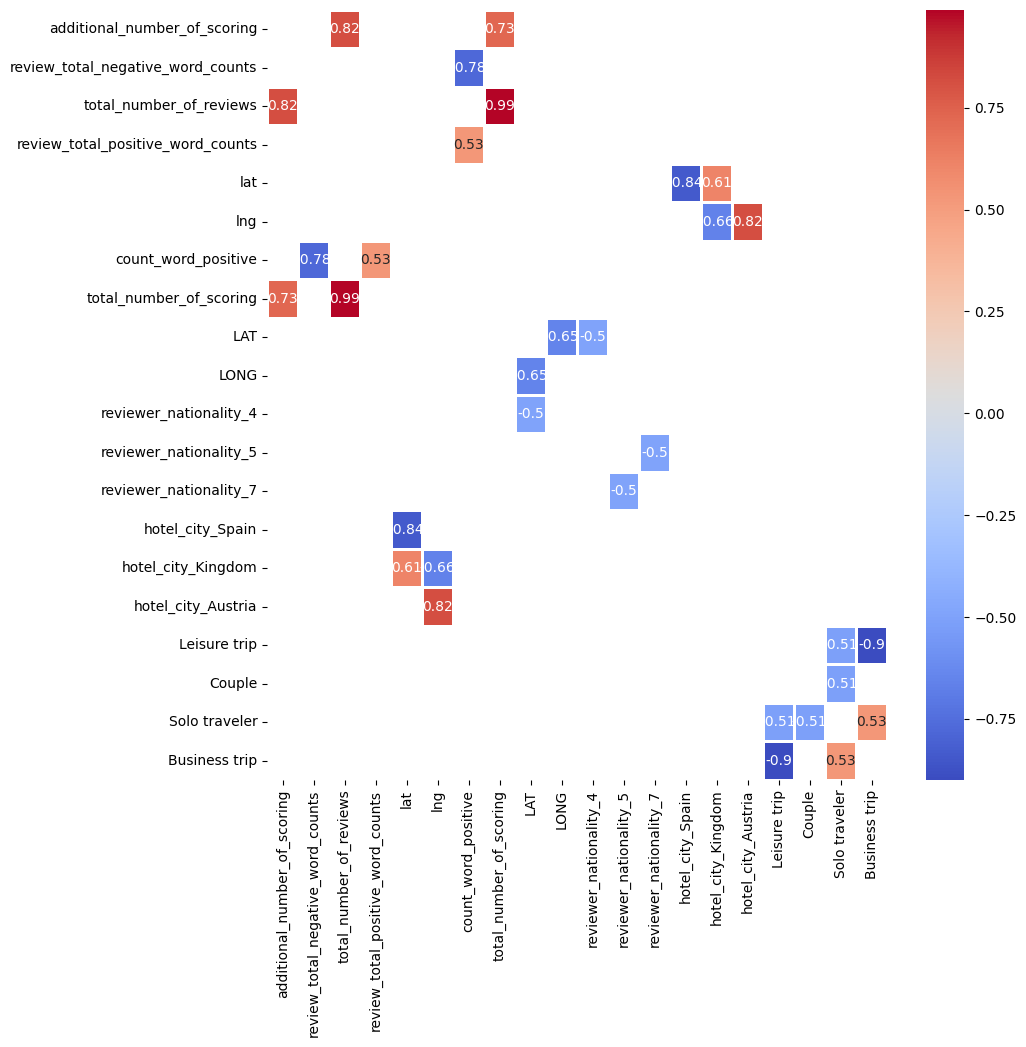

In [84]:
# Посмотрим на признаки с корреляцией более 0.5
pivot = df.drop(['sample'], axis=1)
pivot = round(pivot.corr(numeric_only=True), 2)
for col in pivot:
    pivot[col] = pivot[col].apply(
        lambda x: np.nan if (abs(x) < 0.5 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(pivot, annot=True, linewidths=.9, cmap='coolwarm')

In [85]:
# Удаляем мультиколлинеарные признаки
df = df.drop([
    'total_number_of_reviews', 'additional_number_of_scoring',
    'hotel_city_Spain', 'Leisure trip'], axis=1)

In [86]:
# Вспомогательный код

# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
# object_columns = [s for s in df.columns if df[s].dtypes == 'object']
# df.drop(object_columns, axis=1, inplace=True)

## 4.2 Нормализация


In [87]:
# Просмотр не бинарных признаков
col_upward_2 = list(df.nunique()[df.nunique() > 2].index)
col_upward_2

['average_score',
 'review_total_negative_word_counts',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'reviewer_score',
 'count_word_positive',
 'total_number_of_scoring',
 'LAT',
 'LONG']

array([[<Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'review_total_negative_word_counts'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>,
        <Axes: title={'center': 'days_since_review'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'lng'}>,
        <Axes: title={'center': 'reviewer_score'}>,
        <Axes: title={'center': 'count_word_positive'}>],
       [<Axes: title={'center': 'total_number_of_scoring'}>,
        <Axes: title={'center': 'LAT'}>,
        <Axes: title={'center': 'LONG'}>]], dtype=object)

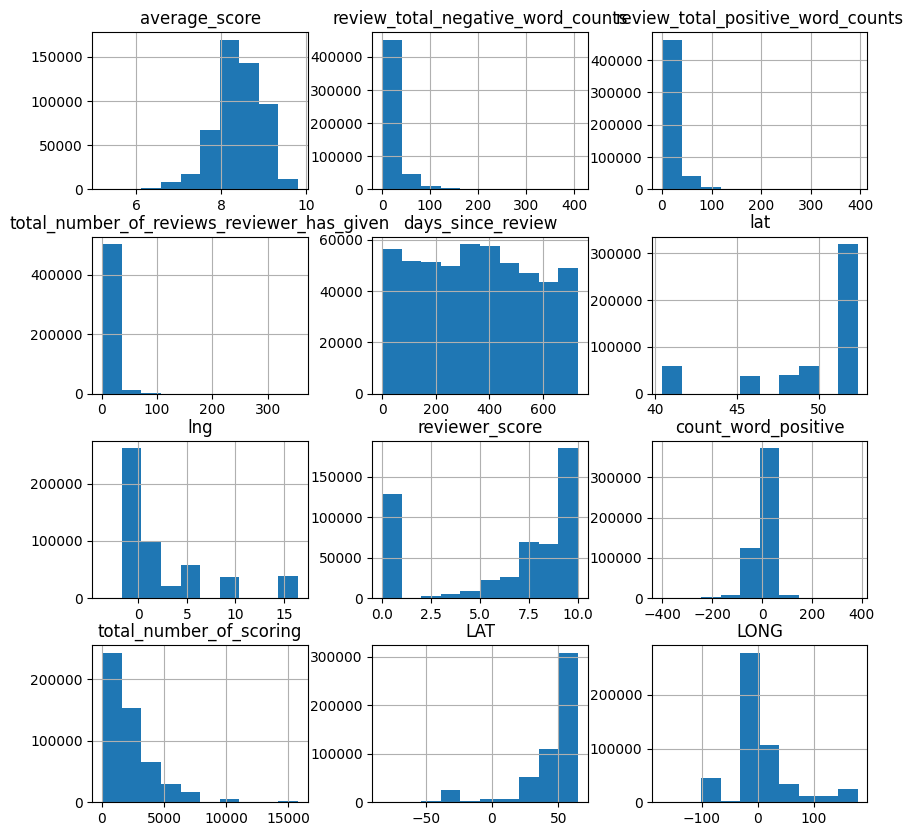

In [88]:
df.loc[:, col_upward_2].hist()


In [89]:
# Преобразование обратного гиперболического синуса для скошенного вправо распределения
log_df_list = ['review_total_negative_word_counts', 'review_total_positive_word_counts',
               'total_number_of_reviews_reviewer_has_given']  # список столбцов для преобразования

In [90]:
log_df = df.loc[:, log_df_list]
for i in log_df_list:
    log_df[i] = np.log(df[i] + np.sqrt(df[i] ** 2 + 1))
log_df

,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
0,4.644483,4.820347,0.881374
1,2.998223,0.000000,2.644121
2,1.818446,2.312438,3.402307
3,0.000000,3.989327,2.893444
4,0.000000,2.644121,1.443635
...,...,...,...
515426,0.000000,2.998223,2.998223
515427,0.000000,5.225776,0.881374
515428,3.179785,2.893444,3.738236
515429,0.000000,2.491780,4.025670


array([[<Axes: title={'center': 'review_total_negative_word_counts'}>,
        <Axes: title={'center': 'review_total_positive_word_counts'}>],
       [<Axes: title={'center': 'total_number_of_reviews_reviewer_has_given'}>,
        <Axes: >]], dtype=object)

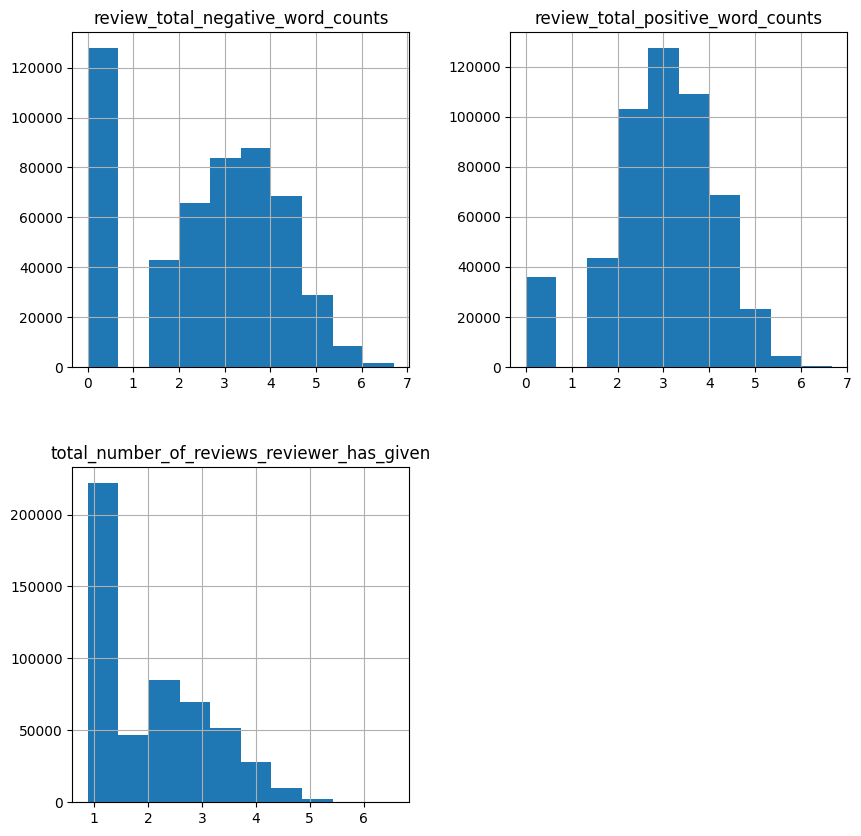

In [91]:
log_df.hist()


In [92]:
# df.loc[:, log_df_list] = log_df # обратное присвоение значений в исходный df


In [93]:
# Остальные столбцы приведем к нормальному распределению с помощью квантильного преобразования
col_upward_2 = ['average_score',
                'days_since_review',
                'lat',
                'lng',
                'count_word_positive',
                'total_number_of_scoring',
                'LAT',
                'LONG']

In [94]:
norm_df = df.loc[:, col_upward_2]


In [95]:
from sklearn.preprocessing import QuantileTransformer

# приведем переменные с выбросами (!) к нормальному распределению
# с помощью квантиль-функции
qt = QuantileTransformer(n_quantiles=int(len(norm_df)/5),  # число квантилей подобрано максимально возможно для вычислительных возможностей машины
                         output_distribution='normal',
                         random_state=42,
                         subsample=len(norm_df))

# для каждого из столбцов вычислим квантили нормального распределения,
# соответствующие заданному выше количеству квантилей (n_quantiles)
# и преобразуем (map) данные к нормальному распределению
norm_df = pd.DataFrame(qt.fit_transform(norm_df),
                       columns=norm_df.columns)

array([[<Axes: title={'center': 'average_score'}>,
        <Axes: title={'center': 'days_since_review'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'lng'}>,
        <Axes: title={'center': 'count_word_positive'}>,
        <Axes: title={'center': 'total_number_of_scoring'}>],
       [<Axes: title={'center': 'LAT'}>,
        <Axes: title={'center': 'LONG'}>, <Axes: >]], dtype=object)

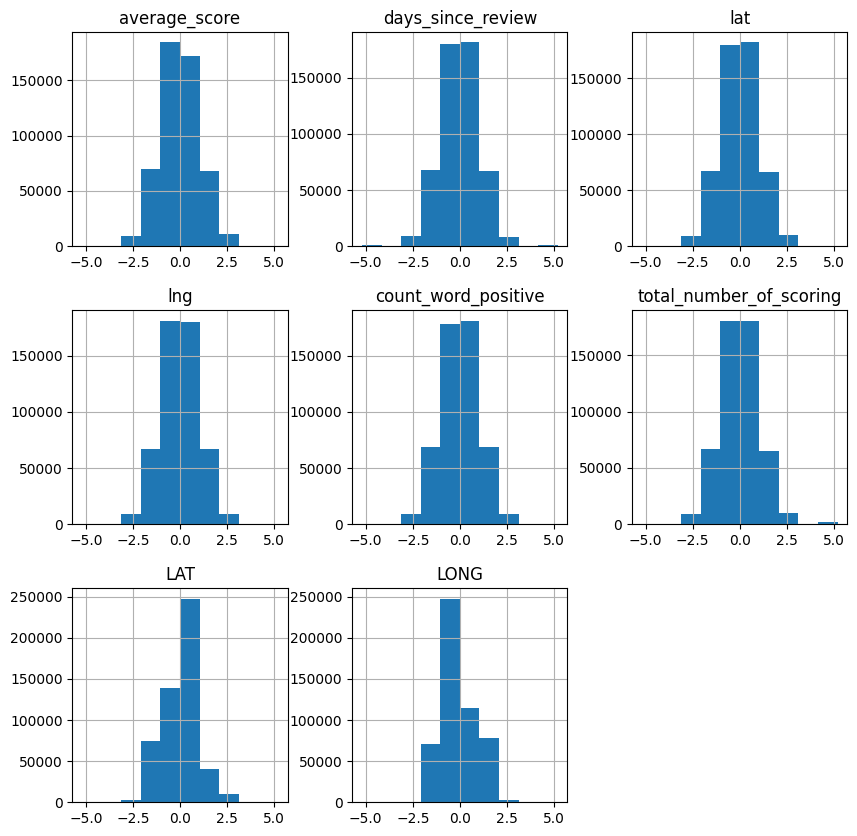

In [96]:
norm_df.hist()

In [97]:
# df.loc[:, norm_df.columns] = norm_df # обратное присвоение значений в исходный df


Вывод приведение данных к нормальному распределению не привело к улучшению модели. RandomForestRegressor не требователен к распределению данных


# 5 Создание модели


In [98]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 82 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   review_total_positive_word_counts           515431 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 4   days_since_review                           515431 non-null  int64  
 5   lat                                         515431 non-null  float64
 6   lng                                         515431 non-null  float64
 7   sample                                      515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   negative_boole                              515431 non-null  int64  
 

In [99]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)


In [100]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [101]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape


((128935, 81), (386496, 81), (386496, 80), (309196, 80), (77300, 80))

In [102]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [103]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [104]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


In [105]:
# Округляем предсказанные значения
y_pred = np.round(y_pred, 1)


In [106]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))


MAE: 0.9092470892626132


In [107]:
print('MAPE:', sum(abs((y_test-y_pred)/y_test))/len(y_test)*100)

MAPE: 13.098382318506774


<Axes: >

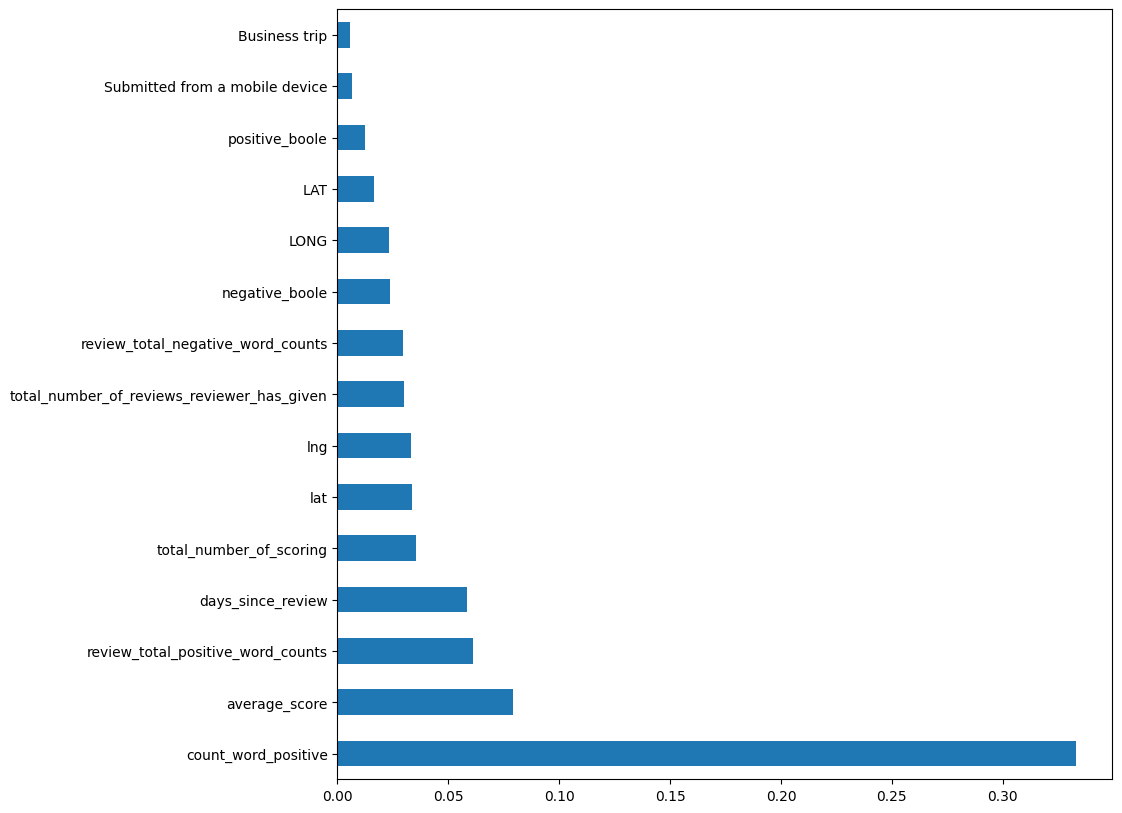

In [108]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [109]:
test_data.sample(10)


,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,negative_boole,positive_boole,...,Deluxe Double Room,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room,Superior Double or Twin Room,2 rooms,Stayed 6 nights,Standard Twin Room,Single Room
39925,9.1,0,35,1,7,51.510237,-0.076443,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
25705,8.1,6,10,1,280,51.499046,-0.191707,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
93017,7.7,2,17,6,14,48.870125,2.311141,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
22181,8.7,70,59,4,358,51.493616,-0.159235,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
28991,9.0,0,8,2,310,52.377743,4.897057,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
62295,8.9,0,70,2,290,51.520631,-0.091534,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
85759,8.7,0,21,12,534,41.393597,2.174272,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
18564,8.5,15,5,30,572,48.213305,16.356788,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
23365,8.5,53,3,7,604,52.363889,4.881302,0.0,1,1,...,0,0,0,0,1,0,0,0,0,0
90153,8.9,16,38,1,10,48.839662,2.330058,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [110]:
test_data = test_data.drop(['reviewer_score'], axis=1)


In [111]:
sample_submission


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [112]:
predict_submission = model.predict(test_data)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.8s finished


In [113]:
predict_submission


array([8.025, 7.297, 7.905, ..., 8.361, 9.498, 7.559])

In [114]:
list(sample_submission)


['reviewer_score', 'id']

In [115]:
sample_submission['reviewer_score'] = np.round(predict_submission, 1)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)


,reviewer_score,id
0,8.0,488440
1,7.3,274649
2,7.9,374688
3,9.7,404352
4,9.5,451596
5,8.5,302161
6,8.2,317079
7,7.5,13963
8,8.9,159785
9,8.5,195089
